### 노동자 성별 예측- 노동자들의 데이터를 보고 성별을 예측하자

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline

#warning messages
import warnings
warnings.filterwarnings('ignore')
#시각화
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
### 그래프 한글 깨짐 해결
import platform
platform.system()
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) #마이너스폰트 설정
#plt.rc('font', family='AppleGothic') - Darwin : Mac  

In [2]:
#데이터 불러오기
train = pd.read_csv('human.csv', encoding='cp949').set_index('아이디')
test = pd.read_csv('human_new.csv', encoding='cp949').set_index('아이디')
train.head()

,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,성별,자본 이득,자본 손실,주당 시간,모국
아이디,,,,,,,,,,,,,,
H20001,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
H20002,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
H20003,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
H20004,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
H20005,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [3]:
#원본 복사
mdf = train.copy()

In [4]:
mdf.isnull().sum()

나이           0
노동 계급     1836
fnlwgt       0
학력           0
교육 수         0
혼인 상태        0
직업        1843
관계           0
인종           0
성별           0
자본 이득        0
자본 손실        0
주당 시간        0
모국         583
dtype: int64

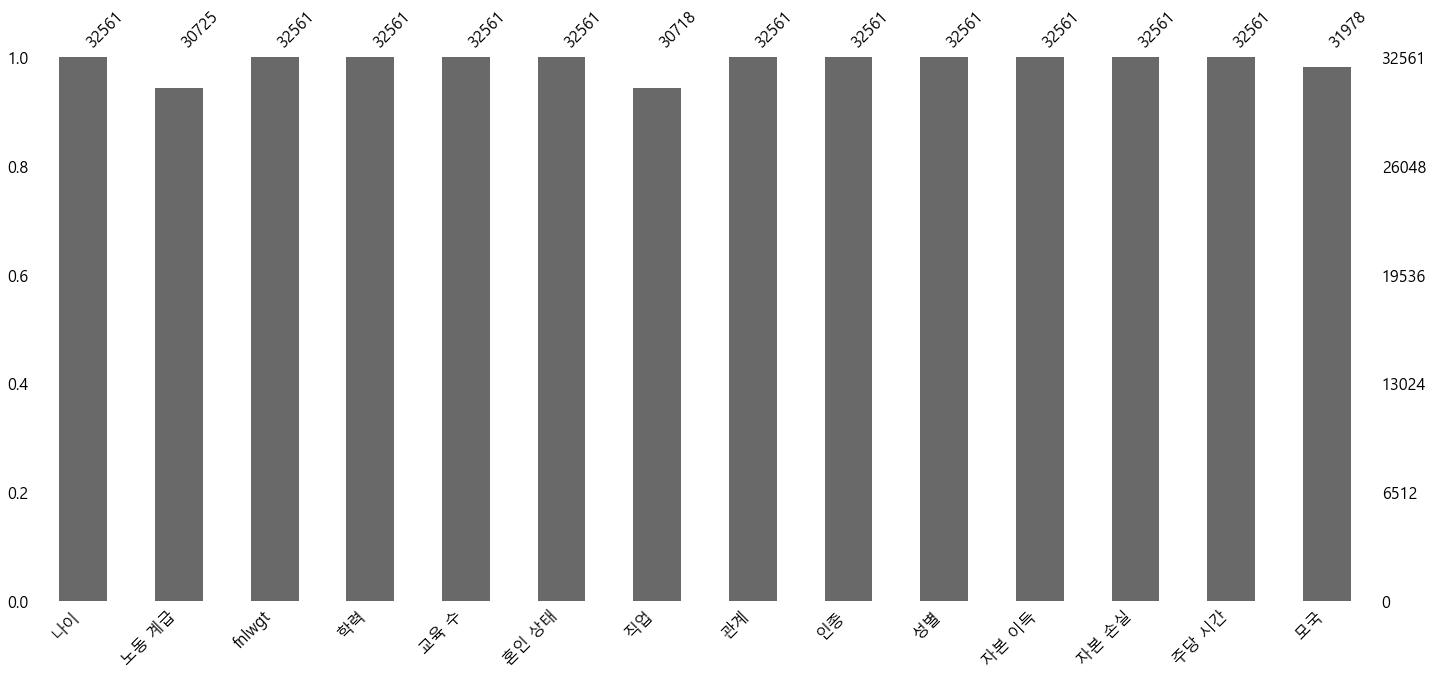

In [5]:
#pip install missingno 설치 -> 결측치 시각화
import missingno as msno
import matplotlib as mpl
#msno.matrix(mdf)
msno.bar(mdf)
plt.show()

In [6]:
#결측값 최빈값 대체 처리 
from sklearn.impute import SimpleImputer
imputer_nul = SimpleImputer(strategy="most_frequent")
nul =['노동 계급','직업','모국']
mdf[nul]=imputer_nul.fit_transform(mdf[nul])

In [7]:
# 결혼 변수 추가
mdf['혼인 상태'] = mdf['혼인 상태'].str.lstrip()
mdf['혼인 상태'].value_counts()   

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: 혼인 상태, dtype: int64

In [8]:
str1 = 'Never-married','Divorced'
def marr(x):
    결혼 = ''
    if x in str1: 결혼 = '무'
    else: 결혼 = '유'
    return 결혼

In [9]:
mdf['결혼'] = mdf['혼인 상태'].apply(lambda x : marr(x))

In [10]:
# '자본 손실' & '자본 이익' 이 있고 없음으로 대체
def com(c):
    if c > 0 : 자본 = 1
    else: 자본 = 0
    return 자본

In [11]:
mdf['자본 손실'] = mdf['자본 손실'].apply(lambda c : com(c))

In [12]:
mdf['자본 이득'] = mdf['자본 이득'].apply(lambda c : com(c))

In [13]:
#배우자 변수 
spo1 = 'Married-AF-spouse'
spo2 = 'Never-married', 'Divorced', 'Separated', 'Widowed'
def spouse(s):
    배우자=''
    if s in spo1 : 배우자 = '군인'
    elif s in spo2 :  배우자 = '무'
    else: 배우자 = '일반'
    return 배우자

In [14]:
mdf['배우자'] =mdf['혼인 상태'].apply(lambda s: spouse(s))

In [15]:
mdf.head()

,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,성별,자본 이득,자본 손실,주당 시간,모국,결혼,배우자
아이디,,,,,,,,,,,,,,,,
H20001,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,40,United-States,무,무
H20002,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,유,일반
H20003,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,무,무
H20004,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,유,일반
H20005,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,유,일반


In [16]:
mdf['직업'].unique()

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

In [25]:
mdf.groupby(['직업','혼인 상태'])['배우자'].count()

직업                 혼인 상태                
 Adm-clerical      Divorced                  819
                   Married-AF-spouse           5
                   Married-civ-spouse        986
                   Married-spouse-absent      59
                   Never-married            1591
                                            ... 
 Transport-moving  Married-civ-spouse        994
                   Married-spouse-absent      19
                   Never-married             340
                   Separated                  37
                   Widowed                    25
Name: 배우자, Length: 89, dtype: int64

In [19]:
mdf['모국'].value_counts()

 United-States                 29753
 Mexico                          643
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 Greece                           29
 

In [ ]:
# 컬럼 drop
#mdf = mdf.drop(['fnlwgt', '학력','자본 손실','자본 이득'], axis=1)
#mdf.head()

In [ ]:
mdf.head()

In [ ]:
#data = pd.concat([mdf['fnlwgt'], mdf['나이']], axis=1)
mdf.plot.scatter(x='fnlwgt', y='성별')

In [ ]:
df_jobs = pd.get_dummies(mdf['직업'])

In [ ]:
mdf = pd.concat([mdf,df_jobs], axis=1)

In [ ]:
mdf = mdf.drop(['직업'], axis=1)

In [ ]:
mdf.head()

In [ ]:
#object, num 구분
obj = mdf.dtypes[mdf.dtypes == 'object'].index
num = mdf.dtypes[mdf.dtypes != 'object'].index
display(obj)
display(num)

In [ ]:
mdf[obj] = mdf[obj].apply(lambda x: x.astype('category').cat.codes)

In [ ]:
## 성별과 각 컬럼 간의 연관성 확인?
corr=mdf.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corr, mask=mask, vmax=1.,annot=True)

## 참고 사이트
# https://www.kaggle.com/fkstepz/step-by-step-predict-bike-sharing-demand

In [ ]:
mdf.describe()

In [ ]:
## 연관성 & 이상치 확인 가능
f, axes = plt.subplots(ncols=2, figsize=(15,8))
sns.boxplot(x="성별", y= "나이", data=mdf, ax=axes[0])
sns.boxplot(x="성별", y= "모국", data=mdf, ax=axes[1])
#plt.show()

In [ ]:
###이상치 제거

In [ ]:
'''
Q1=mdf['나이'].quantile(.25)
Q3 =mdf['나이'].quantile(.75)
IQR = Q3-Q1

print("Q1 =",Q1)
print("Q3 =",Q3)
print("IQR =",IQR)
print("max =",Q3+1.5*IQR)
print("min =",Q1-(1.5*IQR))
'''

In [ ]:
#outliers = mdf['나이'], mdf['주당 시간']
q1 = mdf['나이'].quantile(0.25)
q3 = mdf['나이'].quantile(0.75)
IQR = q3 - q1
old = mdf[(mdf['나이'] < (q1 - 1.5 * IQR)) | (mdf['나이'] > (q3 + 1.5 * IQR))]
old

In [ ]:
# IQR 기준 이상치 행 지우기
mdf = mdf.drop(old.index, axis=0)
mdf.shape

In [ ]:
# 컬럼 drop
#mdf = mdf.drop(['모국', '노동 계급', '자본 손실','자본 이득'], axis=1)
#mdf.head()

In [ ]:
mdf.hist(bins=30, figsize=(20,15))

In [ ]:
'''
f, ax = plt.subplots(1,2,figsize=(10,5))

# 남녀 빈도 체크
gender_freq = mdf.성별.value_counts().sort_values()
gender_freq.plot.pie(explode=[0,0.05], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('남녀 비율')#, fontproperties=font_prop)
ax[0].set_ylabel('')

# 
sns.countplot('성별', data=mdf, ax=ax[1])
ax[1].set_title('결혼') #, fontproperties=font_prop)
plt.show()
#0 f, 1 m
'''

RobustScaler:
모든 특성들이 같은 크기를 갖는다는 점에서 StandardScaler와 비슷하지만, 평균과 분산 대신 median과 quartile을 사용합니다.
RobustScaler는 이상치에 영향을 받지 않습니다

In [ ]:
mdf.shape

In [ ]:
mdf.head()

In [ ]:
from sklearn.model_selection import train_test_split  
X = mdf.drop(['성별'], axis=1) 
Y = mdf['성별']                    
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

### pipeline

In [ ]:
pipe_tree = Pipeline([('scaler', MinMaxScaler()), ('tree',DecisionTreeClassifier())])

In [ ]:
pipe_tree.fit(X_train, y_train).score(X_test, y_test)

In [ ]:
pipe_svm = Pipeline([('scaler', MinMaxScaler()), ('svm',SVC())])

In [ ]:
pipe_svm.fit(X_train, y_train).score(X_test, y_test)

In [ ]:
pipe_xgb = Pipeline([('scaler', MinMaxScaler()), ('xgb',XGBClassifier())])

In [ ]:
#pipe_xgb.fit(X_train, y_train).score(X_test, y_test)

###########################################################################################

In [ ]:
#XGB model

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

params = {'max_depth':4,
          'eta':0.1,
          'objective':'binary:logistic',
          'eval_metric':'logloss',
          'early_stoppings':100
         }
num_rounds = 400

In [ ]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기
wlist = [(dtrain, 'train'),(dtest, 'eval')]
# 하이퍼 파라미터와 early stoppinig 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

In [ ]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

preds = [1 if x > 0.5 else 0 for x in pred_probs]


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [ ]:
get_clf_eval(y_test, preds)

############################# 데이터 불균형 

In [ ]:
#성별 불균형 확인
mdf['성별'].value_counts()

In [ ]:
X_sm, Y_sm = SMOTETomek().fit_sample(X_train, y_train)
sample_tree = DecisionTreeClassifier(max_depth=14, random_state=0)
sample_tree.fit(X_sm, Y_sm)
y_pred_sp = sample_tree.predict(X_test)
print(classification_report(y_test, y_pred_sp))


In [ ]:
'''
X_sm, Y_sm = SMOTETomek().fit_sample(X_train, y_train)
sample_random = RandomForestClassifier(max_depth=12, random_state=0)
sample_random.fit(X_sm, Y_sm)
Y_pred_spran = sample_random.predict(X_test)
print(classification_report(y_test, Y_pred_spran))
'''

In [ ]:
X_to, Y_to = TomekLinks().fit_sample(X_train, y_train)
under_random =RandomForestClassifier(max_depth=6, random_state=0)
under_random.fit(X_to, Y_to)
Y_pred_random = under_random.predict(X_test)
print(classification_report(y_test, Y_pred_random))

In [ ]:
'''
X_to, Y_to = TomekLinks().fit_sample(X_train, y_train) #under-Sampling
under_tree = DecisionTreeClassifier(max_depth=8, random_state=0)
under_tree.fit(X_to, Y_to)
Y_pred_un = under_tree.predict(X_test)
print(classification_report(y_test, Y_pred_un))
'''

In [ ]:
y_train.value_counts()

In [ ]:
Y_to.value_counts()

In [ ]:
#데이터 나누기 - 
X_train, X_test, y_train, y_test = train_test_split(X_to, Y_to, test_size=0.25, random_state=0)
print(X.shape, X_to.shape, X_train.shape, X_test.shape)

In [ ]:
dec_tree = DecisionTreeClassifier(max_depth=8, random_state=0)

dec_tree.fit(X_train, y_train)
print("훈련 세트 정확도: {:.3f}".format(dec_tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(dec_tree.score(X_test, y_test)))

In [ ]:
'''
svm = SVC(C=100)
svm.fit(X_train, y_train).score(X_test, y_test)
print("훈련 세트 정확도: {:.3f}".format(svm.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(svm.score(X_test, y_test)))
'''

##########################################new xgb

In [ ]:
import xgboost
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [ ]:
params = {'max_depth':2,
          'eta':0.1,
          'objective':'binary:logistic',
          'eval_metric':'logloss',
          'early_stoppings':100
         }
num_rounds = 200

In [ ]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기
wlist = [(dtrain, 'train'),(dtest, 'eval')]
# 하이퍼 파라미터와 early stoppinig 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

In [ ]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

preds = [1 if x > 0.5 else 0 for x in pred_probs]

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [ ]:
get_clf_eval(y_test, preds)

In [ ]:
mdf.head()

#################################################### 검증 파일

In [ ]:
test.head()

In [ ]:
ndf = test.copy()
ndf.head()

In [ ]:
ndf.isnull().sum()

In [ ]:
from sklearn.impute import SimpleImputer
imputer_con = SimpleImputer(strategy="most_frequent")  
con = ['노동 계급', '학력', '혼인 상태', '직업', '관계', '인종', '모국']
imputer_con.fit(ndf[con])

In [ ]:
x = imputer_con.transform(ndf[con])
ndf[con] =x

In [ ]:
# 결혼 변수 추가
ndf['혼인 상태'] = ndf['혼인 상태'].str.lstrip()
ndf['혼인 상태'].value_counts()   

In [ ]:
str1 = 'Never-married','Divorced'
def marr(x):
    결혼 = ''
    if x in str1: 결혼 = '무'
    else: 결혼 = '유'
    return 결혼

In [ ]:
ndf['결혼'] = ndf['혼인 상태'].apply(lambda x : marr(x))

In [ ]:
#ndf['자본합'] = ndf['자본 손실']+ndf['자본 이득']

In [ ]:
spo1 = 'Married-AF-spouse'
spo2 = 'Never-married', 'Divorced', 'Separated', 'Widowed'
def spouse(s):
    배우자=''
    if s in spo1 : 배우자 = '군인'
    elif s in spo2 :  배우자 = '무'
    else: 배우자 = '일반'
    return 배우자

In [ ]:
ndf['배우자'] =ndf['혼인 상태'].apply(lambda s: spouse(s))

In [ ]:
# 컬럼 drop
ndf = ndf.drop(['fnlwgt', '학력','자본 손실','자본 이득'], axis=1)
ndf.head()

In [ ]:
ndf_jobs = pd.get_dummies(ndf['직업'])

In [ ]:
ndf = pd.concat([ndf,ndf_jobs], axis=1)

In [ ]:
ndf = ndf.drop(['직업'], axis=1)

In [ ]:
obj1 = ndf.dtypes[ndf.dtypes == 'object'].index
num1 = ndf.dtypes[ndf.dtypes != 'object'].index
display(obj1)
display(num1)

In [ ]:
ndf[obj1] = ndf[obj1].apply(lambda x: x.astype('category').cat.codes)

In [ ]:
X_train.shape

In [ ]:
ndf.shape

In [ ]:
ndf.reset_index(drop=False, inplace=True)

In [ ]:
ndf.head()

In [ ]:
#mdf.reset_index(drop=False, inplace=True)

In [ ]:
dtest_ndf = xgb.DMatrix(data=ndf.loc[:,'나이':])

In [ ]:
ndf['성별'] = xgb_model.predict(dtest_ndf)

In [ ]:
ndf.head()

In [ ]:
str = ['아이디','성별']
ndf[str].head()

In [ ]:
#ndf[str].to_csv('sampleSubmission_human.csv', encoding='cp949', index=False)

In [ ]:
#movie_rename = movie.rename(index={0:'아바타'}, columns={'color':'색깔','director_name':'감독이름'})
ndf_rename = ndf.rename(columns={'아이디':'ID', '성별':'SEX'})
ndf_rename.head()

In [ ]:
str = ['ID','SEX']
ndf_rename[str].head()

In [ ]:
ndf_rename[str].to_csv('mission_0201_2.csv', encoding='cp949', index=False) 

In [ ]:
ndf_rename.shape # 16281 갯수 똑같이 맞춰야 함

In [ ]:
#데이터 전처리 순서 참고 http://www.dodomira.com/2016/10/20/how_to_eda/ 

# 기본 설명 사이트 참고 https://continuous-development.tistory.com/166?category=736685